In [27]:
# importing the required packages
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import stats, skew, kurtosis
from scipy.fftpack import fft
import scipy.stats
import numpy as np
import seaborn as sns


Subject1_cgm_data = pd.read_csv("CGMSeriesLunchPat1.csv")
Subject1_time_stamps = pd.read_csv("CGMDatenumLunchPat1.csv")

# Create a new CGM data frame with the values reversed in ascending order (from past to present) and interpolate
CGM_Data=pd.DataFrame()
total_rows=Subject1_cgm_data.shape[0]
index=total_rows-1
df1=pd.DataFrame()
while index>=0:
    data_arr = Subject1_cgm_data.iloc[index].values
    df1[index] = data_arr[::-1]
    index = index - 1

CGM_Data=CGM_Data.append(df1.transpose())
CGM_Data.interpolate(method='linear', inplace=True)



# Reverse the values in ascending order (from past to present) & convert the time series from EPOCH format
CGM_Time_Stamps = pd.DataFrame()
total_rows=Subject1_time_stamps.shape[0]
index=total_rows-1
df1=pd.DataFrame()
while index>=0:
    data_arr = Subject1_time_stamps.iloc[index].values
    df1[index] = data_arr[::-1]
    index = index - 1

CGM_Time_Stamps = CGM_Time_Stamps.append(df1.transpose())
CGM_Time_Stamps = CGM_Time_Stamps.applymap(lambda i : pd.to_datetime(i - 719529, unit='D'))


# Feature Matrix
Feature_Matrix = pd.DataFrame()

# Feature 1- CGM Velocity (for 30 minute intervals)
Velocity_Data = pd.DataFrame()
win_size=6
total_vals=CGM_Data.shape[1]-win_size

for index in range(0, total_vals):
        dv = CGM_Data.iloc[:, index + win_size] - CGM_Data.iloc[:, index]
        Velocity_Data['vel'+str(index)] = dv

Feature_Matrix['CGM_Velocity']=Velocity_Data.max(axis = 1)



# Feature 2 - Windowed Mean (for 30 min interval)
win_size=6
total_vals = CGM_Data.shape[1]-win_size
for index in range(0, total_vals, win_size):
    dm = CGM_Data.iloc[:, index:index + win_size].mean(axis=1)
    Feature_Matrix['Mean ' + str(index)] = dm



# Feature 3 - Windowed Standard Deviation (for 30 min interval)
win_size=6
total_vals = CGM_Data.shape[1]-win_size
for index in range(0, total_vals, win_size):
    dstd = CGM_Data.iloc[:, index:index + win_size].std(axis=1)
    Feature_Matrix['Std_deviation ' + str(index)] = dstd


# Feature 4 - Fast Fourier Transform
FFT = pd.DataFrame()
def calculate_fft_vals(series):
    FFT_abs = abs(fft(series))
    FFT_abs.sort()
    return np.flip(FFT_abs)[0:8]

FFT['FFT_vals'] = CGM_Data.apply(lambda series: calculate_fft_vals(series), axis=1)
FFT_Vals= pd.DataFrame(FFT.FFT_vals.tolist(), columns=['FFT1', 'FFT2', 'FFT3', 'FFT4', 'FFT5', 'FFT6', 'FFT7', 'FFT8'])


Feature_Matrix = Feature_Matrix.join(FFT_Vals)
Feature_Matrix.head()


 


,CGM_Velocity,Mean 0,Mean 6,Mean 12,Mean 18,Mean 24,Std_deviation 0,Std_deviation 6,Std_deviation 12,Std_deviation 18,Std_deviation 24,FFT1,FFT2,FFT3,FFT4,FFT5,FFT6,FFT7,FFT8
32,43.000000,75.666667,77.333333,82.833333,120.166667,150.333333,1.505545,1.966384,10.438710,7.574079,7.554248,5196.000000,1349.456351,1349.456351,344.274083,344.274083,316.787456,316.787456,200.039542
31,36.571429,98.738095,124.666667,124.666667,130.333333,120.333333,10.223788,4.501851,1.861899,2.804758,9.136009,9298.333333,989.029956,989.029956,299.954120,299.954120,227.383884,227.383884,192.680423
30,42.000000,91.309524,117.166667,113.000000,95.500000,82.833333,6.392225,15.118421,10.373042,1.048809,5.419102,5949.666667,1252.698954,1252.698954,252.065932,252.065932,224.128221,224.128221,142.577246
29,99.714286,171.380952,158.500000,102.500000,114.833333,147.833333,44.009894,12.243366,14.363147,12.188793,10.400321,4679.000000,1128.069701,1128.069701,290.575522,290.575522,161.360985,161.360985,156.961011
28,49.000000,104.619048,112.833333,137.333333,169.500000,172.333333,10.326770,4.535049,18.832596,3.146427,5.750362,4395.000000,385.823785,385.823785,65.209171,65.209171,51.423448,51.423448,43.689401


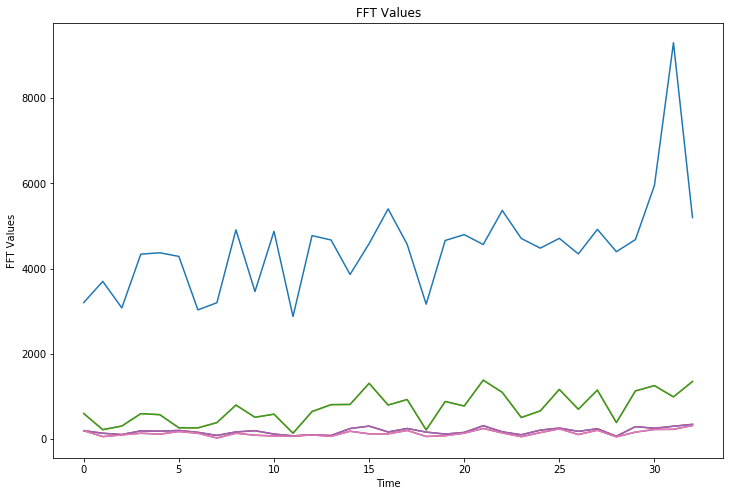

In [15]:
#Plotting fft

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('FFT Values')
ax.set_xlabel('Time')
ax.set_title('FFT Values')
ax.plot(Feature_Matrix.iloc[:,13:20],'-')
plt.show()

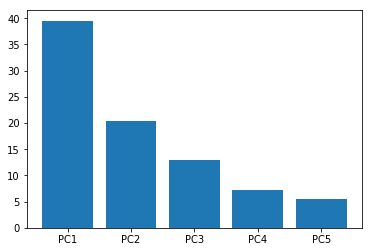

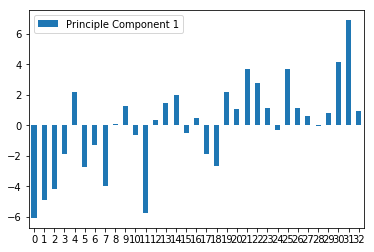

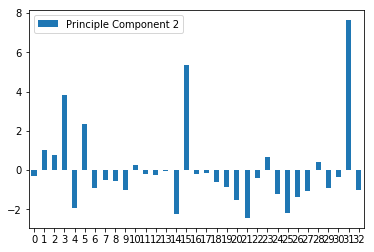

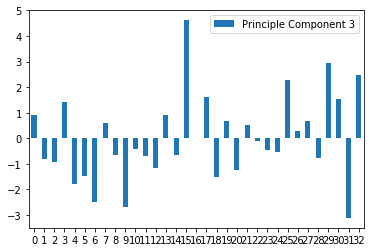

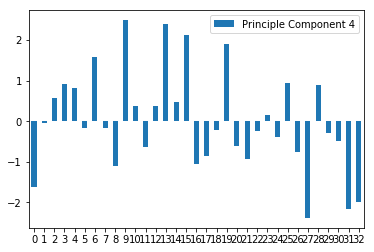

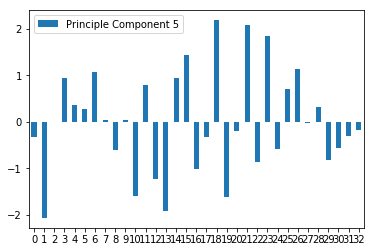

In [16]:
# Standardize feature matrix
Feature_Matrix = StandardScaler().fit_transform(Feature_Matrix)


# PCA

pca = PCA(n_components=5)
PCA_Comps_5 = pca.fit(Feature_Matrix)
Components = pca.fit_transform(Feature_Matrix)

PC_time_series=pd.DataFrame(data=Components,
                           columns = ['Principle Component 1', 'Principle Component 2','Principle Component 3',
                                      'Principle Component 4','Principle Component 5'])


pcs = ['PC1','PC2','PC3','PC4','PC5']
plt.bar(pcs,PCA_Comps_5.explained_variance_ratio_*100)
plt.show()


# Plot components in bar graph
x1 = PC_time_series.plot.bar(y='Principle Component 1', rot=0)
plt.show()
x2 = PC_time_series.plot.bar(y='Principle Component 2', rot=0)
plt.show()
x3 = PC_time_series.plot.bar(y='Principle Component 3', rot=0)
plt.show()
x4 = PC_time_series.plot.bar(y='Principle Component 4', rot=0)
plt.show()
x5 = PC_time_series.plot.bar(y='Principle Component 5', rot=0)
plt.show()

